## Noções de IA - Trabalho 1 - Regressão Linear na qualidade de vinho
##### Integrantes:
            - Lucas Corrêa Boaventura           - 211038262
            - Alexandre Castanho Sampaio Rocha  - 211027536

### Bibliotecas

In [125]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from d2l import tensorflow as d2l
import random

### Classes


In [126]:
class LinearRegression(d2l.Module): #@save
    """The linear regression model implemented with high-level APIs."""
    """Do d2l"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

In [127]:
class LinearRegressionData(d2l.DataModule): #@save
    """Data for linear regression."""
    def __init__(self, nInputs,data,num_train=5197, num_val=1300, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X=data[:,0:nInputs]
        self.y=data[:,nInputs]

@d2l.add_to_class(d2l.DataModule) #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
    buffer_size=shuffle_buffer).batch(self.batch_size)
    
@d2l.add_to_class(LinearRegressionData) #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

### Métodos de Treinamento

In [128]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

### Preparando os dados:

In [129]:
data = pd.read_csv('winequalityN.csv')
data = pd.get_dummies(data[data.columns.to_list()[::-1]]) # inverto para a qualidade estar na coluna 1 e adicionar os dummies nas úlimas colunas
data = data[data.columns.to_list()[::-1]] # reinverto para qualidade estar na última coluna
data = data.fillna(data.mean())
data['quality'] = data['quality'] - 2 # concertar porque a avaliacao estava de 3 a 9, sendo que o trabalho do pdf pede 1 a 7]
data = data.drop('type_red', axis=1) # como só há 2 tipos de vinho, basta uma coluna de True ou False
data = data.drop("free sulfur dioxide", axis=1) # melhora por algum motivo ????????????????
data = data/data.max() # normalizar os dados pelo valor máximo
#data = (data - data.mean())/data.std() # normalizar os dados por z-score
nInputs = len(data.columns) - 1
data


,type_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,0.440252,0.170886,0.216867,0.31459,0.07365,0.386364,0.963445,0.74813,0.225,0.590604,0.571429
1,1.0,0.396226,0.189873,0.204819,0.024316,0.080196,0.3,0.956708,0.822943,0.245,0.637584,0.571429
2,1.0,0.509434,0.177215,0.240964,0.104863,0.081833,0.220455,0.957766,0.812968,0.22,0.677852,0.571429
3,1.0,0.45283,0.14557,0.192771,0.129179,0.094926,0.422727,0.958248,0.795511,0.2,0.66443,0.571429
4,1.0,0.45283,0.14557,0.192771,0.129179,0.094926,0.422727,0.958248,0.795511,0.2,0.66443,0.571429
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,0.0,0.389937,0.379747,0.048193,0.030395,0.1473,0.1,0.957574,0.860349,0.29,0.704698,0.428571
6493,0.0,0.371069,0.348101,0.060241,0.033435,0.101473,0.115909,0.957786,0.877805,0.265608,0.751678,0.571429
6494,0.0,0.396226,0.322785,0.078313,0.034954,0.124386,0.090909,0.958382,0.852868,0.375,0.738255,0.571429
6495,0.0,0.371069,0.408228,0.072289,0.030395,0.12275,0.1,0.958122,0.890274,0.355,0.684564,0.428571


### Reorganizando os dados para treino e validação numa matriz

In [130]:
train_data, val_data = train_test_split(data, test_size=0.2)
train_data_matrix = tf.convert_to_tensor(train_data, dtype=tf.float32)
val_data_matrix = tf.convert_to_tensor(val_data, dtype=tf.float32)
data_matrix = tf.concat((train_data_matrix, val_data_matrix),axis=0)
val_data_matrix


<tf.Tensor: shape=(1300, 12), dtype=float32, numpy=
array([[1.        , 0.44025156, 0.28481013, ..., 0.19      , 0.738255  ,
        0.5714286 ],
       [0.        , 0.5157233 , 0.221519  , ..., 0.405     , 0.738255  ,
        0.5714286 ],
       [1.        , 0.4025157 , 0.15189873, ..., 0.33      , 0.7852349 ,
        0.71428573],
       ...,
       [1.        , 0.4025157 , 0.17088607, ..., 0.24      , 0.6375839 ,
        0.42857143],
       [1.        , 0.43396226, 0.18354431, ..., 0.325     , 0.6979866 ,
        0.5714286 ],
       [0.        , 0.6855346 , 0.33544305, ..., 0.28      , 0.7852349 ,
        0.5714286 ]], dtype=float32)>

### Efetuando o treinamento

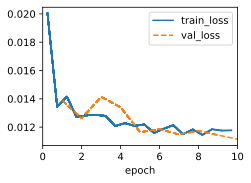

In [131]:
model = d2l.LinearRegression(lr=1e-1)
lr_data = LinearRegressionData(nInputs,data_matrix, num_train=train_data.shape[0], num_val=val_data.shape[0])
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, lr_data)

## Checar a estimativa de erro

### Valor ideal dos pesos

In [132]:
#W_optimal = inv (XT X) XT Y

Xb = tf.concat((data_matrix[:,0:nInputs], tf.ones((6497, 1),dtype=tf.float32)),axis=1)
Y = data_matrix[:,nInputs]
#quad=tf.matmul(tf.transpose(Xb),Xb)
#quad
W_opt = tf.linalg.matvec(tf.linalg.matmul(tf.linalg.inv(tf.matmul(tf.transpose(Xb),Xb)),tf.transpose(Xb)),Y)
#yhat=tf.linalg.matvec(Xb,W)
#yhat[0:5]
W_opt

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([-2.3060085e-02,  2.3835324e-02, -3.7555358e-01, -2.8514938e-02,
        5.6075329e-01, -7.1938045e-02, -1.3690510e-02, -1.3772908e+01,
        2.5486681e-01,  1.9881210e-01,  5.0885665e-01,  1.3127809e+01],
      dtype=float32)>

### Calculando a precisão de acerto

In [133]:
predictions = tf.transpose(model.call(val_data_matrix[:,:nInputs]))[0]
num_cases = len(predictions)
goal = val_data_matrix[:,nInputs]
trivial = tf.convert_to_tensor([4/7 for _ in range(num_cases)], dtype=tf.float32)
kicks = tf.convert_to_tensor([random.randint(1,7)/7 for _ in range(num_cases)], dtype=tf.float32)

accuracy = (len([0 for x in abs(goal - predictions) if x < 0.5/7])/num_cases) * 1e2
trivial_accuracy = (len([0 for x in abs(goal - trivial) if x < 0.5/7])/num_cases) * 1e2
random_accuracy = (len([0 for x in abs(goal - kicks) if x < 0.5/7])/num_cases) * 1e2

print(f'Precisão do modelo linar normalizado: {accuracy:.2f}%')
print(f'Precisão preditor trivial: {trivial_accuracy:.2f}%')
print(f'Precisão preditor aleatório: {random_accuracy:.2f}%')



Precisão do modelo linar normalizado: 50.85%
Precisão preditor trivial: 42.69%
Precisão preditor aleatório: 15.62%
